## Julia Implementation of Host SEIR + Vector SEI

*Author*: Carl A. B. Pearson @pearsonca

*Date*: 2018-10-02

This version considers multiple hosts, which introduces some indexing complications.  This approach adopts the indexing scheme of:

 - all of host $i$ compartments ($S_H$, $E_H$, etc), for $i \in 1\ldots N$
 - vector compartments last

With this approach, we can re-use the solution for one host, with slight modifications:

In [1]:
H_comps = 4
V_comps = 3

# in sub functions, du / u are the particular relevant slices only
function F1H(du,u,p,t,I_V,N_H)
    S_H, E_H, I_H, R_H = u
    
    # host dynamics
    host_infection = (p.β*S_H*I_V)/N_H
    host_mortality = p.μ_H .* u # include S_H, so easier to remove mortality
    host_births = sum(host_mortality)
    host_progression = p.σ_H*E_H
    recovery = p.λ*I_H
    
    du[1] = -host_infection + host_births
    du[2] = host_infection - host_progression
    du[3] = host_progression - recovery
    du[4] = recovery
    du[1:end] -= host_mortality 
end

# in sub functions, du / u are the particular relevant slices only
function FV(du,u,p,t,sum_β_I_H)
    S_V, E_V, I_V = u
    vec_infection = sum_β_I_H*S_V/p.N_H
    vec_mortality = p.μ_V .* u # include S_V, so easier to remove mortality
    vec_births = sum(vec_mortality)
    vec_progression = p.σ_V*E_V
    
    du[1] = -vec_infection + vec_births
    du[2] = vec_infection - vec_progression
    du[3] = vec_progression
    du[1:end] -= vec_mortality
end

function F(du,u,p,t)
    uvec = @view(u[(p.nHosts*H_comps+1):end]) # grab the vector compartments
    S_V, E_V, I_V = uvec
    sum_β_I_H = 0.0
    for host in 0:(p.nHosts-1)
        slice = (1:H_comps).+(H_comps*host)
        F1H(@view(du[slice]), @view(u[slice]), p.host[host+1], t, I_V, p.vec.N_H)
        # must use @view here, so that these arrays can be modified in F1H
        sum_β_I_H += p.host[host+1].β * u[slice[3]] # this host's I compartment
    end
    FV(@view(du[(p.nHosts*4+1):end]), uvec, p.vec,t,sum_β_I_H)
end

F (generic function with 1 method)

First, state initial conditions.  This code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [2]:
nH = 5
srand(0)

S_Hs = ones(nH) .* 100.0
E_Hs = zeros(nH)
I_Hs = shuffle(vcat(zeros(nH-1),[1.0]))
R_Hs = zeros(nH)
host0 = reshape(hcat(S_Hs,E_Hs,I_Hs,R_Hs)', nH*4, 1)
vec0 = [10000.0, 0.0, 0.0]
u0 = vcat(host0, vec0)

23×1 Array{Float64,2}:
   100.0
     0.0
     1.0
     0.0
   100.0
     0.0
     0.0
     0.0
   100.0
     0.0
     0.0
     0.0
   100.0
     0.0
     0.0
     0.0
   100.0
     0.0
     0.0
     0.0
 10000.0
     0.0
     0.0

Now, generate dynamic parameters.  Again: this code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [3]:
srand(1)

μs = 1 ./ (rand(nH) .* 360)
σs = 1 ./ (rand(nH) .* 6)
λs = 1 ./ (rand(nH) .* 28)
βs = rand(nH) ./ 10.0

using NamedTuples
# nb: in >= Julia v0.7, can eliminate this import
#  and the @NT syntax
p = @NT(
  nHosts = nH,
  vec = @NT(μ_V=1/30, σ_V=1/7, N_H = sum(host0)),
  host = [@NT(μ_H=μs[i], σ_H=σs[i], λ=λs[i], β=βs[i]) for i in 1:nH]
  # just building up a random collection of params for demonstration
)

(nHosts = 5, vec = (μ_V = 0.03333333333333333, σ_V = 0.14285714285714285, N_H = 501.0), host = NamedTuples._NT_μ__H_σ__H_λ_β{Float64,Float64,Float64,Float64}[(μ_H = 0.0117686, σ_H = 0.790008, λ = 0.0642631, β = 0.0209472), (μ_H = 0.00801628, σ_H = 0.175085, λ = 0.0817059, β = 0.0251379), (μ_H = 0.00888301, σ_H = 0.166683, λ = 0.0840894, β = 0.00203749), (μ_H = 0.351205, σ_H = 0.662263, λ = 0.0461889, β = 0.0287702), (μ_H = 0.00568503, σ_H = 0.168919, λ = 0.127011, β = 0.0859512)])

Now these values can be used with the ODE solver:

In [4]:
using DifferentialEquations
using IterableTables, DataFrames

tspan = (0.0, 365.0)
prob = ODEProblem(F, u0, tspan, p)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=linspace(0,365,365*10+1))

retcode: Success
Interpolation: 1st order linear
t: 3651-element Array{Float64,1}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   1.0
   1.1
   1.2
   ⋮  
 363.9
 364.0
 364.1
 364.2
 364.3
 364.4
 364.5
 364.6
 364.7
 364.8
 364.9
 365.0
u: 3651-element Array{Array{Float64,2},1}:
 [100.0; 0.0; … ; 0.0; 0.0]                      
 [100.001; 4.05106e-8; … ; 0.041287; 0.000295821]
 [100.002; 3.15487e-7; … ; 0.08154; 0.00117209]  
 [100.004; 1.03672e-6; … ; 0.120779; 0.00261227] 
 [100.005; 2.39309e-6; … ; 0.159026; 0.00460017] 
 [100.006; 4.55256e-6; … ; 0.196298; 0.00711996] 
 [100.007; 7.66377e-6; … ; 0.232616; 0.0101561]  
 [100.008; 1.18579e-5; … ; 0.267998; 0.0136934]  
 [100.009; 1.72497e-5; … ; 0.302464; 0.017717]   
 [100.011; 2.39395e-5; … ; 0.336032; 0.0222123]  
 [100.012; 3.20139e-5; … ; 0.36872; 0.0271651]   
 [100.013; 4.15473e-5; … ; 0.400545; 0.0325615]  
 [100.014; 5.26028e-5; … ; 0.431526; 0.0383877]  
 ⋮                                        

In [5]:
# rename!(df, Dict(:timestamp => :t,
#  :value1 => :S_H, :value2 => :E_H, :value3 => :I_H, :value4 => :R_H,
#  :value5 => :S_V, :value6 => :E_V, :value7 => :I_V
# ))
# mlt[:host] = contains.(string.(mlt[:variable]),"H"); # tag which entries are host vs vector
# df
df = DataFrame(sol)
mlt = melt(df,:timestamp) # convert results into long format for plotting
mlt[:index] = parse.(Int,replace.(string.(mlt[:variable]),r"[^\d]+"=>""))
mlt[:name] = [
    "S_H1","E_H1","I_H1","R_H1",
    "S_H2","E_H2","I_H2","R_H2",
    "S_H3","E_H3","I_H3","R_H3",
    "S_H4","E_H4","I_H4","R_H4",
    "S_H5","E_H5","I_H5","R_H5",
    "S_V","E_V","I_V"
][mlt[:index]]
mlt[:facet] = replace.(string.(mlt[:name]),r"\w+_"=>"")
mlt[:compartment] = replace.(string.(mlt[:name]),r"_\w+"=>"")
mlt

,variable,value,timestamp,index,name,facet,compartment
1,value1,100.0,0.0,1,S_H1,H1,S
2,value1,100.0011761246569,0.1,1,S_H1,H1,S
3,value1,100.00235062049974,0.2,1,S_H1,H1,S
4,value1,100.00352325035139,0.3,1,S_H1,H1,S
5,value1,100.00469378414253,0.4,1,S_H1,H1,S
6,value1,100.00586199875751,0.5,1,S_H1,H1,S
7,value1,100.00702767789407,0.6,1,S_H1,H1,S
8,value1,100.00819061190617,0.7,1,S_H1,H1,S
9,value1,100.00935059768018,0.8,1,S_H1,H1,S
10,value1,100.01050743847112,0.9,1,S_H1,H1,S


Now that we have a solution, we want to view what is happening in host vs mosquito population:

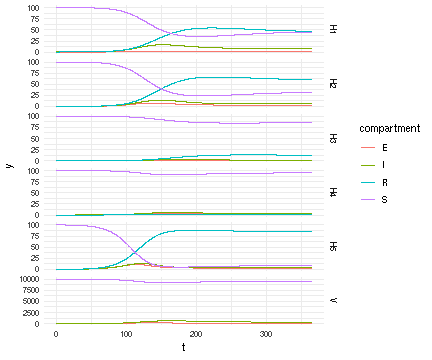

RCall.RObject{RCall.VecSxp}


In [6]:
using RCall
# current version RCall supports better transfers, which would simplify this mess
# but requires Julia v >= 0.7
vals = mlt[:value]
tstamps = mlt[:timestamp]
fcts = mlt[:facet]
comps = mlt[:compartment]
@rput vals tstamps fcts comps
R"
library(ggplot2)
suppressPackageStartupMessages(library(data.table))
dt <- data.table(t=tstamps, y=vals, species=fcts, compartment=comps)
ggplot(dt) + aes(x=t, y=y, color=compartment) + facet_grid(species ~ ., scale = 'free_y') +
  theme_minimal() +
  geom_line()
"